<a href="https://colab.research.google.com/github/mswaringen/aml_food/blob/master/KerasResTransferv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
from keras.applications import resnet
from keras.models import Model,Sequential
import matplotlib.pyplot as plt
from keras.applications.resnet50 import preprocess_input

In [2]:
downzip=True

if downzip:
  !mkdir data
  %cd data
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV" -O final-project-food-recognition-challenge.zip && rm -rf /tmp/cookies.txt
  !unzip final-project-food-recognition-challenge.zip
  %cd ..
  !mkdir outputs

Streaming output truncated to the last 5000 lines.
  inflating: train_set/train_set/train_55.jpg  
  inflating: train_set/train_set/train_550.jpg  
  inflating: train_set/train_set/train_5500.jpg  
  inflating: train_set/train_set/train_5501.jpg  
  inflating: train_set/train_set/train_5502.jpg  
  inflating: train_set/train_set/train_5503.jpg  
  inflating: train_set/train_set/train_5504.jpg  
  inflating: train_set/train_set/train_5505.jpg  
  inflating: train_set/train_set/train_5506.jpg  
  inflating: train_set/train_set/train_5507.jpg  
  inflating: train_set/train_set/train_5508.jpg  
  inflating: train_set/train_set/train_5509.jpg  
  inflating: train_set/train_set/train_551.jpg  
  inflating: train_set/train_set/train_5510.jpg  
  inflating: train_set/train_set/train_5511.jpg  
  inflating: train_set/train_set/train_5512.jpg  
  inflating: train_set/train_set/train_5513.jpg  
  inflating: train_set/train_set/train_5514.jpg  
  inflating: train_set/train_set/train_5515.jpg  
  i

In [48]:
traindf = pd.read_csv('data/train_labels.csv',dtype=str)
testdf = pd.read_csv('data/sample.csv',dtype=str)

datagen = ImageDataGenerator(
                    rotation_range=10,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    preprocessing_function = preprocess_input,
                    validation_split=0.15)

batch_size = 32
image_size = (224,224)

train_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="data/train_set/train_set/",
x_col="img_name",
y_col="label",
subset="training",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size)

valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="data/train_set/train_set/",
x_col="img_name",
y_col="label",
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size)

# test_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(
                    rotation_range=10,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    preprocessing_function = preprocess_input,
                    validation_split=0.15)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="data/test_set/test_set/",
x_col="img_name",
y_col="label",
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=image_size)

Found 26021 validated image filenames belonging to 80 classes.
Found 4591 validated image filenames belonging to 80 classes.
Found 7653 validated image filenames.


In [54]:
np.random.seed(2020)

res = resnet.ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layer in res.layers[:171]:
    layer.trainable=False
    

flat = Flatten()(res.output)   #Flatten the output layer from our Resnet model
dense = Dense(1024,activation='relu')(flat)
drop = Dropout(0.2)(dense)
classifier = Dense(80, activation='softmax')(drop)


res_model = Model(res.input, classifier)
optimizer=optimizers.Adam(1e-5)
# optimizer=optimizers.Adam()


res_model.compile(optimizer= optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Learning rate per epoch:


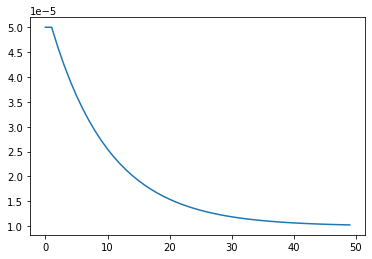

In [55]:
epochs = 50
start_lr = 0.00005
min_lr = 0.00001
max_lr = 0.00005 
rampup_epochs = 0
sustain_epochs = 1
exp_decay = .9

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

rang = np.arange(epochs)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [56]:
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5",verbose=1,save_best_only=True),
    # tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True),
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.01,mode = 'min',
    patience=5,verbose = 0, restore_best_weights = True)]

In [57]:

# res_model.summary()


history = res_model.fit(train_generator,
              epochs=epochs,
              validation_data=valid_generator,
              validation_steps=valid_generator.n//valid_generator.batch_size,
              steps_per_epoch=train_generator.n//train_generator.batch_size,
              callbacks=callbacks,
              verbose=1)

Epoch 1/50
813/813 [==============================] - ETA: 0s - loss: 3.4976 - accuracy: 0.2218
Epoch 00001: val_loss improved from inf to 2.56019, saving model to save_at_1.h5
813/813 [==============================] - 354s 435ms/step - loss: 3.4976 - accuracy: 0.2218 - val_loss: 2.5602 - val_accuracy: 0.3816
Epoch 2/50
813/813 [==============================] - ETA: 0s - loss: 2.3628 - accuracy: 0.4206
Epoch 00002: val_loss improved from 2.56019 to 2.29551, saving model to save_at_2.h5
813/813 [==============================] - 352s 433ms/step - loss: 2.3628 - accuracy: 0.4206 - val_loss: 2.2955 - val_accuracy: 0.4436
Epoch 3/50
813/813 [==============================] - ETA: 0s - loss: 1.9209 - accuracy: 0.5150
Epoch 00003: val_loss improved from 2.29551 to 2.20570, saving model to save_at_3.h5
813/813 [==============================] - 352s 434ms/step - loss: 1.9209 - accuracy: 0.5150 - val_loss: 2.2057 - val_accuracy: 0.4650
Epoch 4/50
813/813 [==============================] - ET

In [59]:
loss, accuracy = res_model.evaluate(valid_generator)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

144/144 [==============================] - 51s 357ms/step - loss: 2.1610 - accuracy: 0.4853
Validation: accuracy = 0.485297  ;  loss = 2.160973 


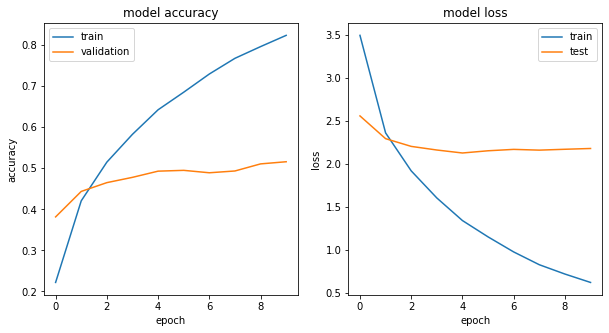

In [60]:


def plot_acc_loss(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
 
plot_acc_loss(history)

In [ ]:
for layer in res.layers[:171]:
    layer.trainable=False

https://heartbeat.fritz.ai/regularization-techniques-for-image-processing-using-tensorflow-56c5b365bc17

In [62]:
test_generator.reset()

pred=res_model.predict(test_generator,
steps=test_generator.n//test_generator.batch_size,
verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"img_name":filenames,
                      "label":predictions})
results.to_csv("results.csv",index=False)

7653/7653 [==============================] - 112s 15ms/step
